# Causal attribution to sales growth and spend intervention

## The Scenario 

Suppose we have an advertiser selling products online. To promote sales, they give out discounts through price promotions, and advertise online through both display ads and sponsored ads in search results pages. To prepare for an upcoming business review, the advertiser compares 2024 and 2023 data and observes steady KPI growth such as sales, and product page views. However, the analytics team wonders what factors drive that growth, is it advertising, price promotion, or simply organic growth due to shopper trends? Answers to this question are key to understanding past growth. Furthermore, this advertiser wants actionable suggestions for business planning, such as spending on areas with higher returns on investment to double down next. <br> In the following scenario, we will use DoWhy two-fold: first to causally attribute KPI growth drivers properly, so the analytics team understands what fueled past growth in a data-driven way. Second, we conduct interventions based on causal impact estimates to derive incremental return on investment (iROI), so the advertiser can forecast future KPI growth with additional investment. These factors and KPIs are: 
* **dsp_spend**: Ad spend on Demand Side Platform (DSP) through display ads
* **sp_spend**: Ad spend on search results pages to bump up product rankings for easy discovery 
* **discount**: Discounts given through price reductions
* **special_shopping_event**: A binary variable indicating whether a shopping event hosted by the ecommerce platform took place, such as Black Friday or Cyber Monday 
* **other_shopping_event**: A binary variable indicating other shopping events off the ecommerce platform. It can be from the advertiser itself, or its advertising with other platforms. 
* **dpv**: Number of product detail page views
* **sale**: Daily revenue on the focal ecommerce platform

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from functools import partial
from dowhy import gcm
from dowhy.utils.plotting import plot

from scipy import stats
from statsmodels.stats.multitest import multipletests

%matplotlib inline

## 1. Explore the data

First, let's load our data representing the spending, discounts, sale and other information for 2023 and 2024. Note that for this simulated data, we didn't change the distribution of price discounts over periods of comparison and shouldn't detect as such in the later attribution model. 

In [2]:
df = pd.read_csv('datasets/sale_attribution.csv', index_col=0)
df.head()

,dsp_spend,sp_spend,dpv,discount,sale,activity_date,year,quarter,month,special_shopping_event,other_shopping_event
0,11864.799390,2609.702789,54954.823150,26167.824599,75554.406731,2023-01-01,2023,1,1,0,0
1,11084.057110,2568.540570,44907.063324,22340.009780,51372.313230,2023-01-02,2023,1,1,0,0
2,16680.850945,2847.576700,151643.912564,68301.747813,626394.881214,2023-01-03,2023,1,1,0,0
3,15473.576264,2788.515831,121173.343955,18906.050402,306000.226338,2023-01-04,2023,1,1,0,0
4,10308.414302,2523.591011,36234.267337,18198.689563,34571.260496,2023-01-05,2023,1,1,0,0


To causally attribute factors of interests to changes, we first need to define time periods for comparisons. 

In [3]:
def generate_new_old_dataframes(df, new_year, new_quarters, new_months, old_year, old_quarters, old_months):
    # Filter new data based on year, quarters, and months
    new_conditions = (df['year'] == new_year) & (df['quarter'].isin(new_quarters)) & (df['month'].isin(new_months))
    df_new = df[new_conditions].copy()

    # Filter old data based on year, quarters, and months
    old_conditions = (df['year'] == old_year) & (df['quarter'].isin(old_quarters)) & (df['month'].isin(old_months))
    df_old = df[old_conditions].copy()

    return df_new, df_old

df_new, df_old = generate_new_old_dataframes(df, new_year=2024, new_quarters=[1,2], new_months=[1,2,3,4,5,6], old_year=2023, old_quarters=[1,2], old_months=[1,2,3,4,5,6])

Then we define cumulative distribution functions to eyeball changes in metrics across two periods. Let's plot them:

In [4]:
def plot_metric_distributions(df_new, df_old, metric_columns):
    for metric_column in metric_columns:
        fig, ax = plt.subplots()
        
        kde_new = stats.gaussian_kde(df_new[metric_column].dropna())
        kde_old = stats.gaussian_kde(df_old[metric_column].dropna())
        
        x_range = np.linspace(
            min(df_new[metric_column].min(), df_old[metric_column].min()),
            max(df_new[metric_column].max(), df_old[metric_column].max()),
            1000
        )
        ax.plot(x_range, kde_new(x_range), color='#FF6B6B', lw=2, label='After')
        ax.plot(x_range, kde_old(x_range), color='#4ECDC4', lw=2, label='Before')
        
        ax.fill_between(x_range, kde_new(x_range), alpha=0.3, color='#FF6B6B')
        ax.fill_between(x_range, kde_old(x_range), alpha=0.3, color='#4ECDC4')

        ax.set_xlabel(metric_column)
        ax.set_ylabel('Density')
        ax.set_title(f'Comparison of {metric_column} distribution')

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(fontsize=10)

        plt.tight_layout()
        plt.show()

Here, we are interested in the 'dpv' and 'sale' variables.

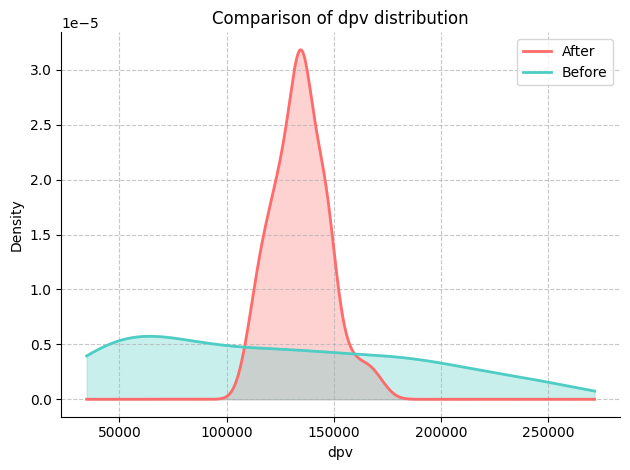

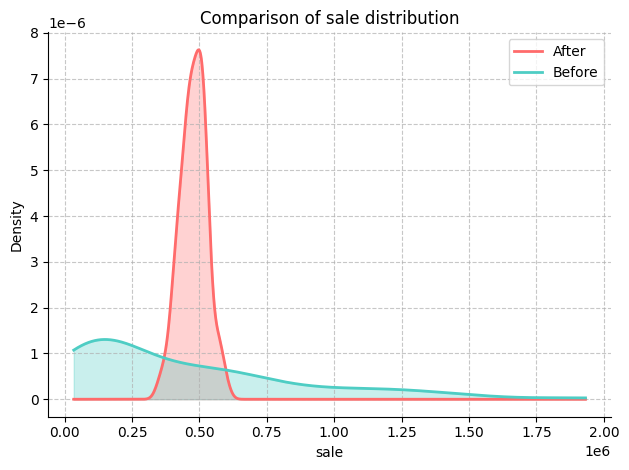

In [5]:
# Define KPI
metric_columns = ['dpv', 'sale']  
plot_metric_distributions(df_new, df_old, metric_columns)

We can further quantify the magnitude of changes by comparing mean, median and variance of both KPIs and potential drivers. 

In [6]:
def compare_metrics(df_new, df_old, metrics):
    comparison_data = []

    for metric in metrics:
        try:
            mean_old = df_old[metric].mean()
            median_old = df_old[metric].median()
            variance_old = df_old[metric].var()
            
            mean_new = df_new[metric].mean()
            median_new = df_new[metric].median()
            variance_new = df_new[metric].var()
            
            if mean_old == 0:
                print(f"Mean for {metric} in the old data is zero. Skipping mean change calculation.")
                mean_change = None
            else:
                mean_change = ((mean_new - mean_old) / mean_old) * 100

            if median_old == 0:
                print(f"Median for {metric} in the old data is zero. Skipping median change calculation.")
                median_change = None
            else:
                median_change = ((median_new - median_old) / median_old) * 100

            if variance_old == 0:
                print(f"Variance for {metric} in the old data is zero. Skipping variance change calculation.")
                variance_change = None
            else:
                variance_change = ((variance_new - variance_old) / variance_old) * 100
            
            comparison_data.append({
                'Metric': metric,
                'Δ mean': mean_change,
                'Δ median': median_change,
                'Δ variance': variance_change
            })
        except KeyError as e:
            print(f"Metric {metric} not found in one of the DataFrames: {e}")
            pass

    comparison_df = pd.DataFrame(comparison_data)
    return comparison_df

For simplicity, below we assume KPIs are revenue (sale), and product views (DPV), with potential drivers including ad spend on demand side platform (dsp_spend) and search results (sp_spend), and price promotion (discount).

In [7]:
comparison_df = compare_metrics(df_new, df_old, ['sale', 'dpv', 'dsp_spend',  'sp_spend', 'discount'])
print(comparison_df)

      Metric     Δ mean   Δ median  Δ variance
0       sale   8.309379  56.847777  -98.588326
1        dpv   8.843596  12.453083  -95.913214
2  dsp_spend   6.387894   3.718354  -66.203836
3   sp_spend  10.335289  10.013358  312.605493
4   discount  -1.837933  32.438169  -99.570962


## 2. Draw causal graph

### 2.1.Set up basic causal graphs 

In the first step, we make use of our domain knowledge that all the ad investment and the shopping events can be potential causes of product page views and sale, but not vice versa. Further, detail page views can also lead to sales, regardless of ad investment. 

In [8]:
edges = []
for col in df.columns:
    if 'spend' in col:
        edges.append((col, 'dpv'))
        edges.append((col, 'sale'))
edges.append(('special_shopping_event', 'dpv')) 
edges.append(('other_shopping_event', 'dpv'))
edges.append(('special_shopping_event', 'sale')) 
edges.append(('other_shopping_event', 'sale'))
edges.append(('discount', 'sale')) 
edges.append(('dpv', 'sale'))

causal_graph = nx.DiGraph(edges)

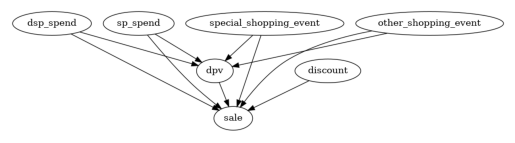

In [9]:
plot(causal_graph)

It is unlikely that all these edges are significant. Let's prune some potential causes in the next step. This is to have a more refined causal graph. i.e, closer to the truth. 

### 2.2. Prune nodes and edges 

One way to prune insignificant causal connections is conducting causal minimality tests through statistical dependence tests. The causality minimality test rules out any parent-child edge ($X\to Y$) for a node $Y$ if $Y$ is conditionally independent of $X$ given other parents of $Y$. If that is the case, node $X$ does not provide additional information on top of the other parents of $Y$. In layman's language, some ads may not provide incremental information in the presence of others. Thus, we can remove those edges of $X \to Y$. Note that the test is adjusted for multihypothesis testing to guarantee a consistent false discovery rate.

In [10]:
def test_causal_minimality(graph, target, data, method='kernel', significance_level=0.10, fdr_control_method='fdr_bh'):
    p_vals = []
    all_parents = list(graph.predecessors(target))
    for node in all_parents:
        tmp_conditioning_set = list(all_parents)
        tmp_conditioning_set.remove(node)
        p_vals.append(gcm.independence_test(data[target].to_numpy(), data[node].to_numpy(), data[tmp_conditioning_set].to_numpy(), method=method))    
        
    if fdr_control_method is not None:
        p_vals = multipletests(p_vals, significance_level, method=fdr_control_method)[1]
        
    nodes_above_threshold = []
    nodes_below_threshold = []
    for i, node in enumerate(all_parents):
        if p_vals[i] < significance_level:
            nodes_above_threshold.append(node)            
        else:
            nodes_below_threshold.append(node)
            
    print("Significant connection:", [(n, target) for n in sorted(nodes_above_threshold)])
    print("Insignificant connection:", [(n, target) for n in sorted(nodes_below_threshold)])
    
    return sorted(nodes_below_threshold)

Then we remove insignificant edges and their associated nodes, resulting a refined causal graph. 

In [11]:
for insignificant_parent in test_causal_minimality(causal_graph, 'sale', df):
    causal_graph.remove_edge(insignificant_parent, 'sale')

cols_to_remove=[]
cols_to_remove.extend([node for node in causal_graph.nodes if causal_graph.in_degree(node) + causal_graph.out_degree(node) == 0])

Significant connection: [('discount', 'sale'), ('dpv', 'sale'), ('dsp_spend', 'sale'), ('sp_spend', 'sale')]
Insignificant connection: [('other_shopping_event', 'sale'), ('special_shopping_event', 'sale')]


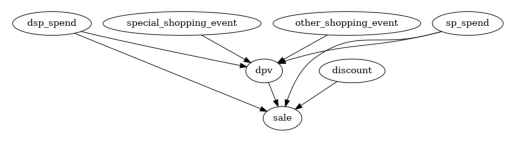

In [12]:
causal_graph.remove_nodes_from(cols_to_remove)
plot(causal_graph)

## 3. Fit causal graph 

Next, we need to assign functional causal models (FCMs) to each node, which describe the data generation process from x to y with an error term. The auto assignment method compares different prediction models for each node and takes the one with the smallest error. The `quality` parameter controls the set of model types that are tested, where `BETTER` indicates some of the most common regression and classification models, such as trees, support vector regression etc. You can also use 'Good' which fits fewer models to speed up, or 'Best' that is computationally heavy. After assigning the models, we can fit them to the data:

In [13]:
causal_model = gcm.StructuralCausalModel(causal_graph)

In [14]:
print(gcm.auto.assign_causal_mechanisms(causal_model, df, quality=gcm.auto.AssignmentQuality.BETTER))

When using this auto assignment function, the given data is used to automatically assign a causal mechanism to each node. Note that causal mechanisms can also be customized and assigned manually.
The following types of causal mechanisms are considered for the automatic selection:

If root node:
An empirical distribution, i.e., the distribution is represented by randomly sampling from the provided data. This provides a flexible and non-parametric way to model the marginal distribution and is valid for all types of data modalities.

If non-root node and the data is continuous:
Additive Noise Models (ANM) of the form X_i = f(PA_i) + N_i, where PA_i are the parents of X_i and the unobserved noise N_i is assumed to be independent of PA_i.To select the best model for f, different regression models are evaluated and the model with the smallest mean squared error is selected.Note that minimizing the mean squared error here is equivalent to selecting the best choice of an ANM.

If non-root node

In [15]:
gcm.fit(causal_model, df)

Fitting causal models:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting causal mechanism of node dsp_spend:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting causal mechanism of node dpv:   0%|          | 0/7 [00:00<?, ?it/s]      

Fitting causal mechanism of node sale:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting causal mechanism of node sale:  43%|████▎     | 3/7 [00:00<00:00, 14.50it/s]

Fitting causal mechanism of node sp_spend:  43%|████▎     | 3/7 [00:00<00:00, 14.50it/s]

Fitting causal mechanism of node special_shopping_event:  43%|████▎     | 3/7 [00:00<00:00, 14.50it/s]

Fitting causal mechanism of node other_shopping_event:  43%|████▎     | 3/7 [00:00<00:00, 14.50it/s]  

Fitting causal mechanism of node discount:  43%|████▎     | 3/7 [00:00<00:00, 14.50it/s]            

Fitting causal mechanism of node discount: 100%|██████████| 7/7 [00:00<00:00, 33.33it/s]

## 4. Identify causal drivers for KPI changes 

To answer the question on drivers for past growth, we test if any of the potential drivers lead to KPI changes by comparing the data from 2023 and 2024. Below we quantify the contribution to changes in the mean of our KPI, but one can similarly estimate the contributions with respect to the median or variance etc. 

In [16]:
def calculate_difference_estimation(causal_model, df_old, df_new, target_column, difference_estimation_func, num_samples=2000, confidence_level=0.90, num_bootstrap_resamples=10):

    difference_contribs, uncertainty_contribs = gcm.confidence_intervals(
        lambda : gcm.distribution_change(causal_model, 
                                          df_old, 
                                          df_new, 
                                          target_column, 
                                          num_samples=num_samples,
                                          independence_test=lambda x, y: gcm.kernel_based(x.astype(float), y.astype(float)),
                                          conditional_independence_test=lambda x, y, z: gcm.kernel_based(x.astype(float), y.astype(float), z.astype(float)),
                                          difference_estimation_func=difference_estimation_func,
                                          shapley_config=gcm.shapley.ShapleyConfig(approximation_method=gcm.shapley.ShapleyApproximationMethods.PERMUTATION, num_permutations=20)),
        confidence_level=confidence_level,
        num_bootstrap_resamples=num_bootstrap_resamples
    )

    return difference_contribs, uncertainty_contribs

median_diff_contribs, median_diff_uncertainty = calculate_difference_estimation(causal_model, df_old, df_new, 'sale', lambda x1, x2: np.mean(x2) - np.mean(x1))

Estimating bootstrap interval...:   0%|          | 0/10 [00:00<?, ?it/s]

Evaluating set functions...:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating set functions...:  10%|█         | 8/79 [00:00<00:01, 52.17it/s]

Evaluating set functions...:  20%|██        | 16/79 [00:00<00:01, 34.43it/s]

Evaluating set functions...:  30%|███       | 24/79 [00:00<00:01, 29.40it/s]

Evaluating set functions...:  41%|████      | 32/79 [00:01<00:01, 29.21it/s]

Evaluating set functions...:  51%|█████     | 40/79 [00:01<00:01, 29.39it/s]

Evaluating set functions...:  61%|██████    | 48/79 [00:01<00:01, 27.71it/s]

Evaluating set functions...:  71%|███████   | 56/79 [00:01<00:00, 28.21it/s]

Evaluating set functions...:  81%|████████  | 64/79 [00:02<00:00, 28.26it/s]

Evaluating set functions...:  91%|█████████ | 72/79 [00:02<00:00, 29.16it/s]

Evaluating set functions...: 100%|██████████| 79/79 [00:02<00:00, 32.07it/s]

Estimating bootstrap interval...:  10%|█         | 1/10 [00:03<00:35,  3.89s/it]

Evaluating set functions...:   0%|          | 0/78 [00:00<?, ?it/s]

Evaluating set functions...:  10%|█         | 8/78 [00:00<00:00, 71.03it/s]

Evaluating set functions...:  21%|██        | 16/78 [00:00<00:01, 31.95it/s]

Evaluating set functions...:  31%|███       | 24/78 [00:00<00:01, 28.79it/s]

Evaluating set functions...:  41%|████      | 32/78 [00:01<00:01, 27.60it/s]

Evaluating set functions...:  51%|█████▏    | 40/78 [00:01<00:01, 28.01it/s]

Evaluating set functions...:  62%|██████▏   | 48/78 [00:01<00:01, 28.58it/s]

Evaluating set functions...:  72%|███████▏  | 56/78 [00:01<00:00, 29.05it/s]

Evaluating set functions...:  82%|████████▏ | 64/78 [00:02<00:00, 28.75it/s]

Evaluating set functions...:  92%|█████████▏| 72/78 [00:02<00:00, 28.60it/s]

Evaluating set functions...: 100%|██████████| 78/78 [00:02<00:00, 31.71it/s]

Estimating bootstrap interval...:  20%|██        | 2/10 [00:07<00:30,  3.82s/it]

Evaluating set functions...:   0%|          | 0/76 [00:00<?, ?it/s]

Evaluating set functions...:  11%|█         | 8/76 [00:00<00:00, 69.92it/s]

Evaluating set functions...:  21%|██        | 16/76 [00:00<00:01, 42.29it/s]

Evaluating set functions...:  32%|███▏      | 24/76 [00:00<00:01, 32.24it/s]

Evaluating set functions...:  42%|████▏     | 32/76 [00:00<00:01, 30.10it/s]

Evaluating set functions...:  53%|█████▎    | 40/76 [00:01<00:01, 29.55it/s]

Evaluating set functions...:  63%|██████▎   | 48/76 [00:01<00:00, 29.26it/s]

Evaluating set functions...:  74%|███████▎  | 56/76 [00:01<00:00, 26.46it/s]

Evaluating set functions...:  84%|████████▍ | 64/76 [00:02<00:00, 28.80it/s]

Evaluating set functions...:  95%|█████████▍| 72/76 [00:02<00:00, 28.76it/s]

Evaluating set functions...: 100%|██████████| 76/76 [00:02<00:00, 31.77it/s]

Estimating bootstrap interval...:  30%|███       | 3/10 [00:11<00:26,  3.72s/it]

Evaluating set functions...:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluating set functions...:  10%|█         | 8/77 [00:00<00:00, 74.94it/s]

Evaluating set functions...:  21%|██        | 16/77 [00:00<00:01, 44.50it/s]

Evaluating set functions...:  31%|███       | 24/77 [00:00<00:01, 32.96it/s]

Evaluating set functions...:  42%|████▏     | 32/77 [00:00<00:01, 30.83it/s]

Evaluating set functions...:  52%|█████▏    | 40/77 [00:01<00:01, 30.31it/s]

Evaluating set functions...:  62%|██████▏   | 48/77 [00:01<00:00, 29.22it/s]

Evaluating set functions...:  73%|███████▎  | 56/77 [00:01<00:00, 29.11it/s]

Evaluating set functions...:  83%|████████▎ | 64/77 [00:02<00:00, 28.19it/s]

Evaluating set functions...:  94%|█████████▎| 72/77 [00:02<00:00, 28.50it/s]

Evaluating set functions...: 100%|██████████| 77/77 [00:02<00:00, 32.44it/s]

Estimating bootstrap interval...:  40%|████      | 4/10 [00:14<00:22,  3.70s/it]

Evaluating set functions...:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating set functions...:  11%|█         | 8/72 [00:00<00:00, 72.71it/s]

Evaluating set functions...:  22%|██▏       | 16/72 [00:00<00:01, 41.36it/s]

Evaluating set functions...:  33%|███▎      | 24/72 [00:00<00:01, 32.36it/s]

Evaluating set functions...:  44%|████▍     | 32/72 [00:00<00:01, 30.60it/s]

Evaluating set functions...:  56%|█████▌    | 40/72 [00:01<00:01, 28.99it/s]

Evaluating set functions...:  67%|██████▋   | 48/72 [00:01<00:00, 28.35it/s]

Evaluating set functions...:  78%|███████▊  | 56/72 [00:01<00:00, 28.17it/s]

Evaluating set functions...:  89%|████████▉ | 64/72 [00:02<00:00, 28.59it/s]

Evaluating set functions...: 100%|██████████| 72/72 [00:02<00:00, 27.79it/s]

Evaluating set functions...: 100%|██████████| 72/72 [00:02<00:00, 29.78it/s]

Estimating bootstrap interval...:  50%|█████     | 5/10 [00:18<00:17,  3.59s/it]

Evaluating set functions...:   0%|          | 0/77 [00:00<?, ?it/s]

Evaluating set functions...:  10%|█         | 8/77 [00:00<00:00, 74.55it/s]

Evaluating set functions...:  21%|██        | 16/77 [00:00<00:01, 41.46it/s]

Evaluating set functions...:  31%|███       | 24/77 [00:00<00:01, 31.22it/s]

Evaluating set functions...:  42%|████▏     | 32/77 [00:00<00:01, 30.51it/s]

Evaluating set functions...:  52%|█████▏    | 40/77 [00:01<00:01, 29.76it/s]

Evaluating set functions...:  62%|██████▏   | 48/77 [00:01<00:01, 28.52it/s]

Evaluating set functions...:  73%|███████▎  | 56/77 [00:01<00:00, 28.71it/s]

Evaluating set functions...:  83%|████████▎ | 64/77 [00:02<00:00, 27.57it/s]

Evaluating set functions...:  94%|█████████▎| 72/77 [00:02<00:00, 27.80it/s]

Evaluating set functions...: 100%|██████████| 77/77 [00:02<00:00, 31.81it/s]

Estimating bootstrap interval...:  60%|██████    | 6/10 [00:22<00:14,  3.64s/it]

Evaluating set functions...:   0%|          | 0/81 [00:00<?, ?it/s]

Evaluating set functions...:  10%|▉         | 8/81 [00:00<00:01, 72.55it/s]

Evaluating set functions...:  20%|█▉        | 16/81 [00:00<00:01, 40.95it/s]

Evaluating set functions...:  30%|██▉       | 24/81 [00:00<00:01, 32.57it/s]

Evaluating set functions...:  40%|███▉      | 32/81 [00:00<00:01, 32.44it/s]

Evaluating set functions...:  49%|████▉     | 40/81 [00:01<00:01, 31.73it/s]

Evaluating set functions...:  59%|█████▉    | 48/81 [00:01<00:01, 31.63it/s]

Evaluating set functions...:  69%|██████▉   | 56/81 [00:01<00:00, 31.37it/s]

Evaluating set functions...:  79%|███████▉  | 64/81 [00:01<00:00, 31.44it/s]

Evaluating set functions...:  89%|████████▉ | 72/81 [00:02<00:00, 30.74it/s]

Evaluating set functions...:  99%|█████████▉| 80/81 [00:02<00:00, 29.46it/s]

Evaluating set functions...: 100%|██████████| 81/81 [00:02<00:00, 32.16it/s]

Estimating bootstrap interval...:  70%|███████   | 7/10 [00:25<00:10,  3.61s/it]

Evaluating set functions...:   0%|          | 0/78 [00:00<?, ?it/s]

Evaluating set functions...:  10%|█         | 8/78 [00:00<00:00, 72.26it/s]

Evaluating set functions...:  21%|██        | 16/78 [00:00<00:01, 41.01it/s]

Evaluating set functions...:  31%|███       | 24/78 [00:00<00:01, 33.87it/s]

Evaluating set functions...:  41%|████      | 32/78 [00:00<00:01, 28.92it/s]

Evaluating set functions...:  51%|█████▏    | 40/78 [00:01<00:01, 28.21it/s]

Evaluating set functions...:  62%|██████▏   | 48/78 [00:01<00:01, 27.62it/s]

Evaluating set functions...:  72%|███████▏  | 56/78 [00:01<00:00, 27.26it/s]

Evaluating set functions...:  82%|████████▏ | 64/78 [00:02<00:00, 27.00it/s]

Evaluating set functions...:  92%|█████████▏| 72/78 [00:02<00:00, 27.79it/s]

Evaluating set functions...: 100%|██████████| 78/78 [00:02<00:00, 31.71it/s]

Estimating bootstrap interval...:  80%|████████  | 8/10 [00:29<00:07,  3.68s/it]

Evaluating set functions...:   0%|          | 0/73 [00:00<?, ?it/s]

Evaluating set functions...:  11%|█         | 8/73 [00:00<00:00, 75.98it/s]

Evaluating set functions...:  22%|██▏       | 16/73 [00:00<00:01, 41.09it/s]

Evaluating set functions...:  33%|███▎      | 24/73 [00:00<00:01, 32.95it/s]

Evaluating set functions...:  44%|████▍     | 32/73 [00:00<00:01, 31.19it/s]

Evaluating set functions...:  55%|█████▍    | 40/73 [00:01<00:01, 30.25it/s]

Evaluating set functions...:  66%|██████▌   | 48/73 [00:01<00:00, 29.05it/s]

Evaluating set functions...:  77%|███████▋  | 56/73 [00:01<00:00, 27.99it/s]

Evaluating set functions...:  88%|████████▊ | 64/73 [00:02<00:00, 28.34it/s]

Evaluating set functions...:  99%|█████████▊| 72/73 [00:02<00:00, 28.12it/s]

Evaluating set functions...: 100%|██████████| 73/73 [00:02<00:00, 30.57it/s]

Estimating bootstrap interval...:  90%|█████████ | 9/10 [00:32<00:03,  3.59s/it]

Evaluating set functions...:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating set functions...:  11%|█         | 8/72 [00:00<00:00, 69.85it/s]

Evaluating set functions...:  22%|██▏       | 16/72 [00:00<00:01, 39.03it/s]

Evaluating set functions...:  33%|███▎      | 24/72 [00:00<00:01, 30.51it/s]

Evaluating set functions...:  44%|████▍     | 32/72 [00:00<00:01, 29.94it/s]

Evaluating set functions...:  56%|█████▌    | 40/72 [00:01<00:01, 29.29it/s]

Evaluating set functions...:  67%|██████▋   | 48/72 [00:01<00:00, 28.32it/s]

Evaluating set functions...:  78%|███████▊  | 56/72 [00:01<00:00, 29.68it/s]

Evaluating set functions...:  89%|████████▉ | 64/72 [00:02<00:00, 29.26it/s]

Evaluating set functions...: 100%|██████████| 72/72 [00:02<00:00, 29.81it/s]

Evaluating set functions...: 100%|██████████| 72/72 [00:02<00:00, 30.57it/s]

Estimating bootstrap interval...: 100%|██████████| 10/10 [00:36<00:00,  3.52s/it]

Estimating bootstrap interval...: 100%|██████████| 10/10 [00:36<00:00,  3.62s/it]

Then we plot drivers' contribution to KPI changes visually, followed by a tabular format. 

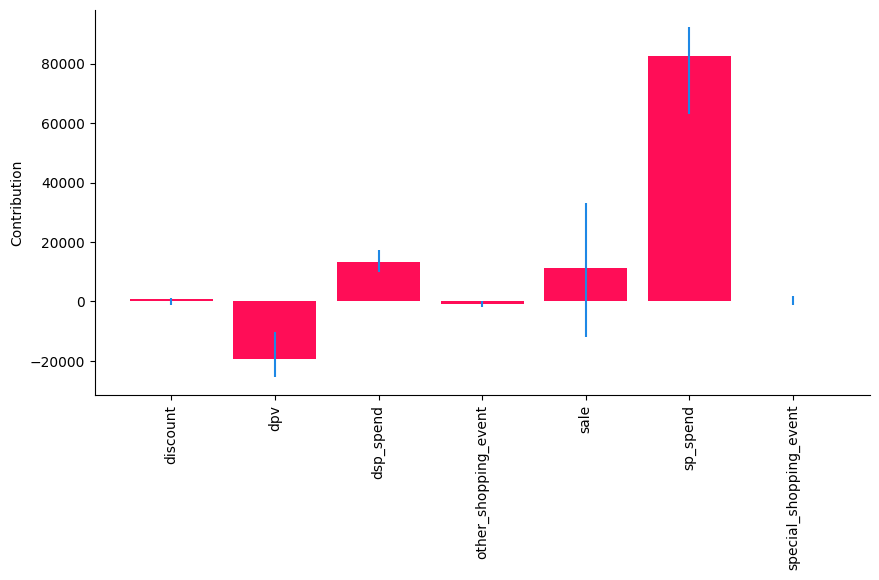

In [17]:
gcm.util.bar_plot(median_diff_contribs, median_diff_uncertainty, 'Contribution', figure_size=(10,5))

In [18]:
def show_tabular(median_contribs, uncertainty_contribs):
    rows = []
    for node, median_contrib in median_contribs.items():
        rows.append(dict(node=node, median=median_contrib, lb=uncertainty_contribs[node][0], ub=uncertainty_contribs[node][1]))
    df = pd.DataFrame(rows).set_index('node')
    df.rename(columns=dict(median='median', lb='lb', ub='ub'), inplace=True)
    return df
    
# show_tabular(median_contribs, uncertainty_contribs)
result_df = pd.DataFrame(show_tabular(median_diff_contribs, median_diff_uncertainty))
result_df

,median,lb,ub
node,,,
discount,852.535415,-1053.680637,1210.905146
dpv,-19499.189182,-25482.030914,-10452.068109
dsp_spend,13108.642561,9770.368215,17339.718242
other_shopping_event,-853.410405,-1858.997967,67.381014
sale,11275.084665,-12035.488901,33166.743585
sp_spend,82411.384817,63133.855478,92262.743812
special_shopping_event,274.665982,-1349.220735,1666.358150


Here, we see that 'sp_spend' has the larges contrigution to the change in the mean of 'sale', while the 'discount', 'other_shopping_event' and 'special_shopping_event' has little to none contribution. This aligns with the way how the data was generated.

Next, we remove all variables that have a 0 as part of their confidence interval or are negative, i.e., do not have a clear significant positive contribution:

In [19]:
def filter_significant_rows(result_df, direction, ub_col, lb_col):

    if direction == 'positive':
        significant_rows = result_df[(result_df[ub_col] > 0) & (result_df[lb_col] > 0)]
    elif direction == 'negative':
        significant_rows = result_df[(result_df[ub_col] < 0) & (result_df[lb_col] < 0)]
    else:
        raise ValueError("Invalid direction. Choose 'positive' or 'negative'.")

    return significant_rows

In [20]:
positive_significant_rows = filter_significant_rows(result_df, 'positive', 'ub', 'lb')
positive_significant_rows

,median,lb,ub
node,,,
dsp_spend,13108.642561,9770.368215,17339.718242
sp_spend,82411.384817,63133.855478,92262.743812


This tells us, 'dsp_spend' and 'sp_spend' had a significantly positive contribution to the shift in 'sale'.

## 5. Optimal intervention

Section 4 above helps us to understand drivers for past growth. Now, looking forward to business planning, we conduct interventions to understand incremental contributions to KPIs. Intuitively, the spend types resulting in higher returns should be doubled down on.  

In [21]:
def intervention_influence(causal_model, target, data=None, step_size=1, non_interveneable_nodes=None, confidence_level=0.90, cap_value=None,  prints=False):
    progress_bar_was_on = gcm.config.show_progress_bars

    if progress_bar_was_on:
        gcm.config.disable_progress_bars()
    
    causal_effects = {}
    causal_effects_confidence_interval = {}
    capped_effects = []

    if non_interveneable_nodes is None:
        non_interveneable_nodes = []
    
    for node in causal_model.graph.nodes:
        if node in non_interveneable_nodes:
            continue

        # Define interventions
        def intervention(x):
            return x + step_size

        def non_intervention(x):
            return x
            
        interventions_alternative = {node: intervention}
        interventions_reference = {node: non_intervention}

        # Compute causal effects
        if data is not None:
            effect = gcm.confidence_intervals(
                gcm.fit_and_compute(gcm.average_causal_effect,
                                    causal_model,
                                    auto_assign_quality=gcm.auto.AssignmentQuality.GOOD,
                                    bootstrap_training_data=data,
                                    target_node=target,
                                    interventions_alternative=interventions_alternative,
                                    interventions_reference=interventions_reference,
                                    observed_data=data),
                n_jobs=1,
                num_bootstrap_resamples=10,
                confidence_level=confidence_level)
        else:
            effect = gcm.confidence_intervals(
                partial(gcm.average_causal_effect,
                        causal_model=causal_model,
                        target_node=target,
                        interventions_alternative=interventions_alternative,
                        interventions_reference=interventions_reference,
                        observed_data=data,
                        num_samples_to_draw=10000),
                n_jobs=-1,
                num_bootstrap_resamples=20,
                confidence_level=confidence_level)


        causal_effects[node] = effect[0][0]
        causal_effects_confidence_interval[node] = effect[1].squeeze()
        
        # Apply capping constraint
        if cap_value is not None and node.endswith('_spend'):
            if causal_effects[node] > cap_value:
                causal_effects[node] = cap_value
                capped_effects.append(node)
            elif causal_effects[node] < -cap_value:
                causal_effects[node] = -cap_value
                capped_effects.append(node)

        # Apply non-negativity constraint
        if  node.endswith('_spend') and causal_effects[node] < 0:
            causal_effects[node] = 0
            causal_effects_confidence_interval[node] = [np.nan, np.nan]

    if progress_bar_was_on:
        gcm.config.enable_progress_bars()

    if prints:
        for node in sorted(causal_effects, key=causal_effects.get, reverse=True):
            if causal_effects[node] == 0:
                print(f"{'Increasing' if step_size > 0 else 'Decreasing'} {node} by {step_size} has no effect on {target}.")
            else:
                print(f"{'Increasing' if step_size > 0 else 'Decreasing'} {node} by {step_size} {'increases' if causal_effects[node] > 0 else 'decreases'} {target} "
                        f"by around {causal_effects[node]} with a confidence interval ({confidence_level * 100}%) of {causal_effects_confidence_interval[node]}.")

    all_variables = list(causal_effects.keys())
    all_causal_effects = [causal_effects[key] for key in all_variables]
    all_lower_bounds = [causal_effects_confidence_interval[key][0] for key in all_variables]
    all_upper_bounds = [causal_effects_confidence_interval[key][1] for key in all_variables]
    result_df = pd.DataFrame({'Variable': all_variables, 
                              'Causal Effect': all_causal_effects, 
                              'Lower CI': all_lower_bounds, 
                              'Upper CI': all_upper_bounds},
                             index = all_variables)
    
    return result_df

In [22]:
interv_result = intervention_influence(causal_model=causal_model, target='sale', non_interveneable_nodes=['dpv', 'sale'], confidence_level=0.85, cap_value=20, prints=True)
interv_result

Increasing sp_spend by 1 increases sale by around 20 with a confidence interval (85.0%) of [211.15203243 283.88797398].
Increasing dsp_spend by 1 increases sale by around 4.520327391584288 with a confidence interval (85.0%) of [-10.80262657  20.16217763].
Increasing discount by 1 increases sale by around 0.6872599796537543 with a confidence interval (85.0%) of [0.12375244 1.30657707].
Increasing other_shopping_event by 1 increases sale by around 5.820766091346741e-12 with a confidence interval (85.0%) of [0. 0.].
Increasing special_shopping_event by 1 increases sale by around 2.9103830456733705e-12 with a confidence interval (85.0%) of [0.00000000e+00 8.73114914e-12].


,Variable,Causal Effect,Lower CI,Upper CI
dsp_spend,dsp_spend,4.520327e+00,-10.802627,2.016218e+01
sp_spend,sp_spend,2.000000e+01,211.152032,2.838880e+02
special_shopping_event,special_shopping_event,2.910383e-12,0.000000,8.731149e-12
other_shopping_event,other_shopping_event,5.820766e-12,0.000000,0.000000e+00
discount,discount,6.872600e-01,0.123752,1.306577e+00


We similarly filter to positively significant interventions, i.e., the spending with statistically significant positive returns.  Note that with capping, 'causal effect' may not fall between lower and upper CI. The interpretation is, for each dollar spent on one type of ad, we receive X amount in return, with X indicated in the 'Causal Effect' column. 

In [23]:
interv_result_v2= filter_significant_rows(interv_result, 'positive', 'Upper CI', 'Lower CI')
interv_result_v2

,Variable,Causal Effect,Lower CI,Upper CI
sp_spend,sp_spend,20.00000,211.152032,283.887974
discount,discount,0.68726,0.123752,1.306577


## Summary

This advertiser comes to us to understand what drove past growth. Starting with a causal graph drawn from domain knowledge, we refined the graph to prune unnecessary nodes and edges. Then we fit a causal attribution model in Section 4 to test which types of investment changes lead to KPI growth. We find that increases in both dsp_spend and sp_spend contribute to KPIs growth in 2024 vs. 2023. This conclusion helps the analytics team to understand root causes of past sales growth. Looking forward to future budget planning, we conducted interventions to understand incremental return on investment (iROI), and identify those types of spend way above $1 to double down on.